# 2.6 概率
- **目录**
  - 2.6.1 基本概率论
  - 2.6.2 处理多个随机变量
  - 2.6.3 期望和方差

## 2.6.1 基本概率论

- 掷骰子是一个概率论中的常用例子，想知道骰子1点朝上的几率有多大。
  - 如果骰子是公平的，那么所有六个结果$\{1, \ldots, 6\}$都有相同的可能发生，因此$1$点朝上发生的概率为$\frac{1}{6}$。
- 检查骰子的唯一方法是多次投掷并记录结果。对于每个骰子，我们将观察到$\{1, \ldots, 6\}$中的一个值。
- 对于每个值，一种自然的方法是将它出现的次数除以投掷的总次数，即此**事件（event）**概率的**估计值**。
- **大数定律（law of large numbers）** 表明：随着投掷次数的增加，这个估计值会越来越接近真实的潜在概率。

In [1]:
%matplotlib inline
import torch
from torch.distributions import multinomial
from d2l import torch as d2l

- 在统计学中，把从概率分布中抽取样本的过程称为**抽样（sampling）**。
- 把**分布（distribution）** 看作是对事件的概率分配，
- 将概率分配给一些离散选择的分布称为**多项分布（multinomial distribution）**。
- 为了抽取一个样本，即掷骰子，只需传入一个概率向量。
- 输出是另一个相同长度的向量：它在索引$i$处的值是采样结果中$i$出现的次数。


In [2]:
fair_probs = torch.ones([6]) / 6
multinomial.Multinomial(1, fair_probs).sample(), fair_probs

(tensor([0., 0., 0., 0., 0., 1.]),
 tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]))

- 可使用深度学习框架Pytorch的函数同时抽取多个样本，快速得到任意形状的独立样本数组。

In [3]:
multinomial.Multinomial(10, fair_probs).sample()

tensor([2., 0., 3., 3., 0., 2.])

- 模拟10000次投掷，对骰子进行采样。
- 统计10000次投掷后，每个数字被投中了多少次。
- 计算**相对频率**，以作为真实概率的**估计**。


In [4]:
# 将结果存储为32位浮点数以便进行除法
counts = multinomial.Multinomial(10000, fair_probs).sample()
counts, counts / 10000  # 相对频率作为估计值

(tensor([1707., 1613., 1668., 1729., 1622., 1661.]),
 tensor([0.1707, 0.1613, 0.1668, 0.1729, 0.1622, 0.1661]))

- 上述例子是从一个公平的骰子中生成的数据，而且每个结果都有真实的概率$\frac{1}{6}$，大约是$0.167$，所以上面输出的估计值看起来不错。
可以看到这些概率如何随着时间的推移收敛到真实概率。
- 下面例子进行500组实验，每组抽取10个样本。
- 图中每条实线对应于骰子的6个值中的一个，并给出骰子在每组实验后出现值的估计概率。
- 通过更多的实验获得更多的数据时，这$6$条实体曲线向真实概率收敛。

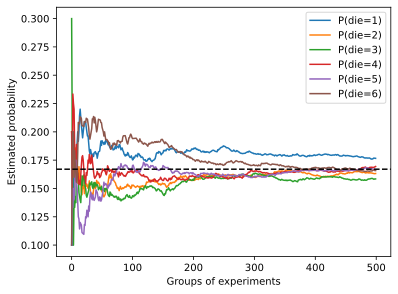

In [5]:
counts = multinomial.Multinomial(10, fair_probs).sample((500,))
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)

d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(),
                 label=("P(die=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color='black', linestyle='dashed')
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

In [6]:
# cum_counts最后一行数据，是500组实验最后的累加抽样数据
# 可见最后6个值已经非常接近，这也是对大数定律的一个验证
cum_counts[-1,], counts.shape

(tensor([883., 816., 792., 847., 833., 829.]), torch.Size([500, 6]))

------------------
- **说明：多项分布**
  - **定义：**
    - 假设我们有一个试验，这个试验有 $ k $ 种可能的结果，每种结果的出现概率分别为 $ p_1, p_2, \ldots, p_k $，其中 $ \sum_{i=1}^k p_i = 1 $。我们进行 $ n $ 次独立的试验，并且每次试验的结果是互相独立的。
    - 设 $ X_i $ 表示第 $ i $ 种结果出现的次数，那么随机向量 $ (X_1, X_2, \ldots, X_k) $ 就服从参数为 $ n $ 和 $ (p_1, p_2, \ldots, p_k) $ 的多项分布，记作：
     $$(X_1, X_2, \ldots, X_k) \sim \text{Multinomial}(n, p_1, p_2, \ldots, p_k)$$

  - 多项分布的**概率质量函数（PMF）** 为：
    $$
    P(X_1 = x_1, X_2 = x_2, \ldots, X_k = x_k) = \frac{n!}{x_1! x_2! \cdots x_k!} p_1^{x_1} p_2^{x_2} \cdots     p_k^{x_k}
    $$
    其中 $ x_1 + x_2 + \cdots + x_k = n $。
  - **示例**：
    - 假设我们有一个袋子，里面有三种颜色的球：红色、蓝色和绿色。红色球的比例是 $ p_1 = 0.2 $，蓝色球的比例是 $ p_2 = 0.5 $，绿色球的比例是 $ p_3 = 0.3 $。我们从袋子中随机抽取10个球，想知道每种颜色的球分别抽到的次数。
    - 设 $ X_1 $ 表示红色球的个数，$ X_2 $ 表示蓝色球的个数，$ X_3 $ 表示绿色球的个数。那么 $ (X_1, X_2, X_3) $ 服从参数为 $ n = 10 $ 和 $ (p_1, p_2, p_3) = (0.2, 0.5, 0.3) $ 的多项分布。
    - 例如，想要计算抽到2个红色球、5个蓝色球和3个绿色球的概率，可以使用多项分布的PMF公式：
      $$
      P(X_1 = 2, X_2 = 5, X_3 = 3) = \frac{10!}{2! 5! 3!} (0.2)^2 (0.5)^5 (0.3)^3
      $$

  - 多项分布在实际中有很多应用，如投票结果的分析、DNA序列的碱基分布、市场调查中的消费者偏好等。
 

In [7]:
import torch
import torch.distributions as dist

# 设定参数
n = 10  # 抽取次数
p1 = 0.2  # 红色球的比例
p2 = 0.5  # 蓝色球的比例
p3 = 0.3  # 绿色球的比例

# 创建多项分布
# total_count参数表示试验的总次数或样本总数
# probs 参数表示多项分布中各个类别的概率
multinomial_dist = dist.Multinomial(total_count=n, probs=torch.tensor([p1, p2, p3]))
# 计算抽到2个红色球、5个蓝色球和3个绿色球的概率
prob = multinomial_dist.log_prob(torch.tensor([2, 5, 3])).exp()
print(prob)

tensor(0.0851)


----------

- #### **概率论公理**
  - 在处理骰子掷出时，我们将集合$\mathcal{S} = \{1, 2, 3, 4, 5, 6\}$
称为**样本空间（sample space）**或**结果空间（outcome space）**，
其中每个元素都是**结果（outcome）**。
  - **事件（event）** 是一组给定样本空间的随机结果。
例如，“看到$5$”（$\{5\}$）和“看到奇数”（$\{1, 3, 5\}$）都是掷出骰子的有效事件。
注意，如果一个随机实验的结果在$\mathcal{A}$中，则事件$\mathcal{A}$已经发生。
也就是说，如果投掷出$3$点，因为$3 \in \{1, 3, 5\}$，我们可以说，“看到奇数”的事件发生了。

  - **概率**（probability）可以被认为是将集合映射到真实值的函数。
    - 在给定的样本空间$\mathcal{S}$中，事件$\mathcal{A}$的概率，表示为$P(\mathcal{A})$，满足以下属性：
      * 对于任意事件$\mathcal{A}$，其概率从不会是负数，即$P(\mathcal{A}) \geq 0$；
      * 整个样本空间的概率为$1$，即$P(\mathcal{S}) = 1$；
      * 对于**互斥（mutually exclusive）** 事件（对于所有$i \neq j$都有$\mathcal{A}_i \cap \mathcal{A}_j = \emptyset$）的任意一个可数序列$\mathcal{A}_1, \mathcal{A}_2, \ldots$，序列中任意一个事件发生的概率等于它们各自发生的概率之和，即$$P(\bigcup_{i=1}^{\infty} \mathcal{A}_i) = \sum_{i=1}^{\infty} P(\mathcal{A}_i)$$
  - 假设事件$\mathcal{A}_1$为整个样本空间，且当所有$i > 1$时的$\mathcal{A}_i = \emptyset$，那么可以证明$P(\emptyset) = 0$，即不可能发生事件的概率是$0$。

- #### **随机变量**
  - **随机变量（random variable）** 几乎可以是任何数量，并且它可以在随机实验的一组可能性中取一个值。
    - 考虑一个随机变量$X$，其值在掷骰子的样本空间$\mathcal{S}=\{1,2,3,4,5,6\}$中。
我们可以将事件“看到一个$5$”表示为$\{X=5\}$或$X=5$，其概率表示为$P(\{X=5\})$或$P(X=5)$。
    - 通过$P(X=a)$，我们区分了随机变量$X$和$X$可以采取的值（例如$a$）。
  - 可以将$P(X)$表示为随机变量$X$上的*分布*（distribution）：分布告诉我们$X$获得某一值的概率。
  - 也可以简单用$P(a)$表示随机变量取值$a$的概率。
  - 由于概率论中的事件是来自样本空间的一组结果，因此我们可以为随机变量指定值的**可取范围**。
    - 例如，$P(1 \leq X \leq 3)$表示事件$\{1 \leq X \leq 3\}$，即$\{X = 1, 2, \text{or}, 3\}$的概率。同时，$P(1 \leq X \leq 3)$表示随机变量$X$从$\{1, 2, 3\}$中取值的概率。

  - 随机变量可以分为：**离散（discrete）** 随机变量（如骰子的每一面）和**连续（continuous）** 随机变量（如人的体重和身高）。

----------
- **说明：常见概率分布模型**
- **离散型概率分布模型**

| 分布名称 | 参数 | 概率质量函数 | 应用场景 |
| --- | --- | --- | --- |
| 二项分布（Bernoulli） | $p$ | $P(X = k) = p^k (1-p)^{1-k}$ | 二分类问题 |
| 多项分布（Multinomial） | $p_1, p_2, \ldots, p_k$ | $P(X = x) = \frac{n!}{x_1! x_2! \cdots x_k!} p_1^{x_1} p_2^{x_2} \cdots p_k^{x_k}$ | 多分类问题 |
| 泊松分布（Poisson） | $\lambda$ | $P(X = k) = \frac{e^{-\lambda} \lambda^k}{k!}$ | 计数数据 |
| 几何分布（Geometric） | $p$ | $P(X = k) = p (1-p)^k$ | 等待时间 |
| 负二项分布（Negative Binomial） | $r, p$ | $P(X = k) = \frac{(k+r-1)!}{k! (r-1)!} p^r (1-p)^k$ | 等待时间 |

  - **常用连续型概率分布模型**

| 分布名称 | 参数 | 概率密度函数 | 应用场景 |
| --- | --- | --- | --- |
| 正态分布（Normal） | $\mu, \sigma^2$ | $f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$ | 连续变量 |
| 均匀分布（Uniform） | $a, b$ | $f(x) = \frac{1}{b-a}$ | 连续变量 |
| 指数分布（Exponential） | $\lambda$ | $f(x) = \lambda e^{-\lambda x}$ | 等待时间 |
| 伽马分布（Gamma） | $\alpha, \beta$ | $f(x) = \frac{1}{\Gamma(\alpha)} \beta^\alpha x^{\alpha-1} e^{-\beta x}$ | 等待时间 |
| 贝塔分布（Beta） | $\alpha, \beta$ | $f(x) = \frac{1}{B(\alpha, \beta)} x^{\alpha-1} (1-x)^{\beta-1}$ | 比例数据 |
  - 上表中的参数涵义如下：
    * $p$：概率
    * $\lambda$：事件发生率
    * $\mu$：均值
    * $\sigma^2$：方差
    * $\alpha$：形状参数
    * $\beta$：尺度参数
    * $a$：下限
    * $b$：上限
    * $r$：成功次数

----------

## 2.6.2 处理多个随机变量
- 多元随机变量在深度学习中的应用场景：
  - 深度学习主要处理的数据类型——图像包含数百万像素，因此可被视为数百万个随机变量。
    - 图像数据会附带一个**标签（label）**，标识图像中的对象。
  - 输入数据建模：
    - 图像处理：每个像素可以看作一个随机变量。
    - 自然语言处理：词向量或句子嵌入可以视为多元随机变量。
    - 多模态学习：结合文本、图像、音频等多种输入。
  - 神经网络层：
    - 全连接层的权重和偏置可以视为多元随机变量。
    - 卷积层的卷积核也是多元随机变量。
- 总而言之，当处理多个随机变量时，其中会有部分变量是机器学习和深度学习感兴趣的处理对象。
  - 这些变量可视为**特征**，能够更好地识别和区别数据对象。

- **联合概率（joint probability）** 的表示：$P(A=a,B=b)$。
  - 给定任意值$a$和$b$，联合概率可以回答：$A=a$和$B=b$同时满足的概率是多少？
  - 请注意，对于任何$a$和$b$的取值，$P(A = a, B=b) \leq P(A=a)$。
  - 这点是确定的，因为要同时发生$A=a$和$B=b$，$A=a$就必须发生，$B=b$也必须发生（反之亦然）。
  - 因此，$A=a$和$B=b$同时发生的可能性不大于$A=a$或是$B=b$单独发生的可能性。

- **联合概率示例：抛硬币和掷骰子**
  - 进行两个独立的随机实验：抛一枚硬币和掷一个六面骰子。
  - 定义事件：
    - $A$: 硬币的结果。
    - $B$: 骰子的点数。
  - 可能的结果：
    - $A$ 可以是 "正面"($H$) 或 "反面"($T$)。
    - $B$ 可以是 $1, 2, 3, 4, 5,6$中任一个。
  - 考虑联合概率 $P(A=a, B=b)$：
    - $P(A=H, B=4)$ 表示硬币正面朝上且骰子点数为4的概率。
      - $P(A=H, B=4) = P(A=H) × P(B=4) = 1/2 × 1/6 = 1/12$
    - $P(A=T, B=1)$ 表示硬币反面朝上且骰子点数为1的概率。
      - $P(A=T, B=1) = P(A=T) × P(B=1) = 1/2 × 1/6 = 1/12$
  - 验证 $P(A=a, B=b) ≤ P(A=a)$ 的不等式：
    - 对于第一个例子：$P(A=H, B=4) = 1/12 ≤ P(A=H) = 1/2$
    - 对于第二个例子：$P(A=T, B=1) = 1/12 ≤ P(A=T) = 1/2$
  - 结论：
    - 联合概率如何表示两个事件同时发生的概率。
    - 联合概率总是小于或等于其中任一单独事件的概率。
    - 在独立事件的情况下，联合概率等于单独事件概率的乘积。

- **条件概率**
  - 联合概率的不等式带来一个有趣的比率：
  $0 \leq \frac{P(A=a, B=b)}{P(A=a)} \leq 1$。
  - 称这个比率为**条件概率（conditional probability）**。
  - 用$P(B=b \mid A=a)$表示条件概率：它是$B=b$的概率，前提是$A=a$已发生。

- **条件概率示例：抽牌游戏**
  - 有一副标准的$52$张扑克牌，从中随机抽出一张牌。
  - 定义事件：
    - $A$: 抽出的是红色牌（红心或方块）
    - $B$: 抽出的是点数为$K$（国王）的牌
  - 计算条件概率 $P(B=K | A=红色)$，即在已知抽出的是红色牌的条件下，这张牌是$K$的概率。
  - 计算步骤：
    -  $P(A=红色) = 26/52 = 1/2$ （因为红色牌有$26$张）
    -  $P(B=K) = 4/52 = 1/13$ （因为$K$总共有$4$张）
    -  $P(A=红色, B=K) = 2/52 = 1/26$（因为红色的$K$有$2$张）
  - 计算条件概率：
    - $P(B=K | A=红色) = P(A=红色, B=K) / P(A=红色)  = (1/26) / (1/2)  = 1/13$
  - 解释：
    - 在已知抽出的是红色牌的情况下，这张牌是$K$的概率是$1/13$。
    - 注意：此概率等于在整副牌中抽出$K$的概率（也是$1/13$），因为牌的颜色和点数是独立的。

- **全概率公式（Law of Total Probability）**
  - 计算某事件总概率的方法，特别是在这个事件可能通过多个**互斥**途径发生的情况下。
    - 全概率公式是一种将复杂事件的概率分解为一系列简单事件概率之和的方法。
    - 其基于此思想：如果可以将样本空间划分为若干个互斥且完备的事件，那么任何事件发生的概率可以表示为在这些划分下发生的概率之和。
  - 全概率公式的数学表达：
    - 假设{B₁, B₂, ..., Bₙ}是一组互斥且完备的事件（即它们的并集是整个样本空间，且两两之间没有交集），对于任意事件A，我们有：
    $$P(A) = P(A|B_1)P(B_1) + P(A|B_2)P(B_2) + ... + P(A|B_n)P(B_n)$$
    - 或者用数学符号表示为：
    $$P(A) = ∑_i P(A|B_i)P(B_i)$$
  - 全概率示意图：
    <center><img src=../img/2_6_1.png width=400px></center>
    <center>图2.6.1 全概率示意图</center>

- **全概率公式示例：医院急诊室诊断**
  - 背景：
    - 一个人到急诊室就诊，可能患有疾病D。
    - 医生可能进行两种检查：X光检查（X）或血液检查（B）。
    - X光检查的概率是$60\%$，血液检查的概率是$40\%$。
    - 如果进行X光检查，正确诊断疾病D的概率是$80\%$。
    - 如果进行血液检查，正确诊断疾病D的概率是$70\%$。
  - 问题：这个病人被正确诊断出患有疾病D的概率是多少？
  - 解：让事件$A$表示"正确诊断出疾病D"，可以将情况分为两种：进行X光检查和进行血液检查。
  - 使用全概率公式：$P(A) = P(A|X)P(X) + P(A|B)P(B)$
    - 其中：
      - $P(X) = 0.60$ （X光检查的概率）
      - $P(B) = 0.40$ （血液检查的概率）
      - $P(A|X) = 0.80$ （X光检查下正确诊断的概率）
      - $P(A|B) = 0.70$ （血液检查下正确诊断的概率）
    - 代入数值：$P(A) = 0.80 * 0.60 + 0.70 * 0.40 = 0.48 + 0.28 = 0.76$
    - 病人被正确诊断出患有疾病D的概率是$76\%$。

- **乘法规则（multiplication rule ）**
  - 公式推导：
    - 从条件概率的定义开始：
     $$P(B|A) = \frac{P(A, B)}{P(A)}$$
    - 将这个等式两边同乘以 $P(A)$，我们得到：
      $$P(B|A) \cdot P(A) = P(A, B)$$
  - 应用示例：
    - 假设有一个装有3个红球和2个蓝球的袋子，连续取出两个球（不放回），取出的两个球都是红球的概率是多少？
  - 解：
    - 令A为第一次取出红球，B为第二次取出红球
    - $P(A) = 3/5$（第一次取红球的概率）
    - $P(B|A) = 2/4$（在已经取出一个红球的条件下，第二次取红球的概率）
    - $P(A, B) = P(B|A) P(A) = (2/4) * (3/5) = 3/10$

- **Bayes定理（Bayes' theorem）**
  - 根据**乘法法则（multiplication rule ）** 可得到$P(A, B) = P(B \mid A) P(A)$。
  - 根据对称性，可得到$P(A, B) = P(A \mid B) P(B)$。
  - 假设$P(B)>0$，求解其中一个条件变量，可得到：
    $$P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}.$$
  - 此处使用紧凑的表示法：
    - 其中$P(A, B)$是一个**联合分布（joint distribution）**。
    - $P(A \mid B)$是一个**条件分布（conditional distribution）**。
    - 这种分布可以在给定值$A = a, B=b$上进行求值。

- **Bayes定理应用示例：乳腺癌筛查**
  - 背景：
    - 在一个人群中，1%的女性患有乳腺癌。
    - 乳腺癌筛查的灵敏度（sensitivity）是$90\%$，即如果一个女性患有乳腺癌，测试结果$90\%$的概率会呈阳性。
    - 筛查的特异性（specificity）是$90\%$，即如果一个女性没有乳腺癌，测试结果$90\%$的概率会呈阴性。
  - 问题：如果一位女性的乳腺癌筛查结果呈阳性，她实际患有乳腺癌的概率是多少？
  - 解：
    - 定义事件：
      - $A$：患有乳腺癌
      - $B$：筛查结果呈阳性
    - 已知信息：
      - $P(A) = 1\% = 0.01$（患病率）
      - $P(B|A) = 90\% = 0.9$（灵敏度）
      - $P(B|not A) = 10\% = 0.1$（$1$ - 特异性）
    - 计算 $P(A|B)$，即在筛查结果呈阳性的条件下，实际患有乳腺癌的概率。
      - 使用贝叶斯定理：$P(A|B) = [P(B|A) * P(A)] / P(B)$
      - 计算 $P(B)$：
        $$P(B) = P(B|A) * P(A) + P(B|not A) * P(not A)$$
        $$ = 0.9 * 0.01 + 0.1 * 0.99 = 0.009 + 0.099   = 0.108$$
      - 计算 $P(A|B)：P(A|B) = (0.9 * 0.01) / 0.108 ≈ 0.0833$
      - 将结果转换为百分比：$0.0833 * 100\% ≈ 8.33\%$
    - 结论：如果一位女性的乳腺癌筛查结果呈阳性，她实际患有乳腺癌的概率约为$8.33\%$。
  - 本示例展示了贝叶斯定理在实际问题中的应用，特别是在医学诊断领域。
    - 说明了即使测试结果呈阳性，实际患病的概率可能仍然相对较低。
    - 此分析有助于医生和患者更好地理解诊断结果并做出进一步检查的决定。

- **边际化（marginalization）**
  - 为了能进行事件概率求和，需使用**求和法则（sum rule）**，
  - 即$B$的概率相当于计算$A$的所有可能选择，并将所有选择的联合概率聚合在一起，即可得到边际化公式：
    $$P(B) = \sum_{A} P(A, B),$$
  
  - 边际化结果的概率或分布称为**边际概率（marginal probability）**或**边际分布（marginal distribution）**。

- **边际化示例：员工满意度调查**
  - 背景：
    - 一家小公司对其员工进行了满意度调查。调查包括两个方面：
      - 工作环境满意度（$A$）：分为"满意"和"不满意"
      - 薪资满意度（$B$）：分为"高"、"中"和"低"
    - 调查结果以联合概率分布的形式呈现：
| 工作环境($A$) | 薪资($B$) | $P(A,B)$ |
|-------------|---------|--------|
| 满意        | 高      | 0.15   |
| 满意        | 中      | 0.25   |
| 满意        | 低      | 0.10   |
| 不满意      | 高      | 0.05   |
| 不满意      | 中      | 0.30   |
| 不满意      | 低      | 0.15   |

  - 计算薪资满意度（$B$）的边际概率分布：
    - 解决方案：使用边际化公式：$P(B) = ∑_a P(A,B)$
      - $P(B = 高) = P(满意, 高) + P(不满意, 高) = 0.15 + 0.05 = 0.20$
      - $P(B = 中) = P(满意, 中) + P(不满意, 中) = 0.25 + 0.30 = 0.55$
      - $P(B = 低) = P(满意, 低) + P(不满意, 低) = 0.10 + 0.15 = 0.25$
    - 薪资满意度（B）的边际概率分布为：
      - $P(B = 高) = 0.20 (20\%)$
      - $P(B = 中) = 0.55 (55\%)$
      - $P(B = 低) = 0.25 (25\%)$
  - 解释：
    - 这个边际分布告诉我们员工对薪资的总体满意度，不考虑他们对工作环境的看法。
    - 可以看到，大多数员工（$55\%$）认为薪资处于中等水平。
    - 高薪资和低薪资的员工比例相对较少，分别为$20\%$和$25\%$。

- **独立性**
  - 概率中一个有用属性是**依赖（dependence）**与**独立（independence）**。

  - 如果两个随机变量$A$和$B$是独立的，意味着事件$A$的发生跟$B$事件的发生无关。
  - 在这种情况下，统计学家通常将这一点表述为$A \perp  B$，称之为A独立于B或A与B互相独立。
  - 根据贝叶斯定理，马上就能同样得到$P(A \mid B) = P(A)$。
  - 在所有其他情况下，我们称$A$和$B$依赖。
  - 比如：两次连续抛出一个骰子的事件是相互独立的。    
  - 由于$P(A \mid B) = \frac{P(A, B)}{P(B)} = P(A)$等价于$P(A, B) = P(A)P(B)$，
  - 因此**两个随机变量是独立的，当且仅当两个随机变量的联合分布是其各自分布的乘积**。
  - 同样地，给定另一个随机变量$C$时，两个随机变量$A$和$B$是**条件独立的（conditionally independent）**，
  - 当且仅当$P(A, B \mid C) = P(A \mid C)P(B \mid C)$。
  - 这个情况表示为$A \perp B \mid C$。

## 2.6.3 期望和方差

- 随机变量$X$的**期望（expectation）** 表示为

  $$E[X] = \sum_{x} x P(X = x).$$
  当函数$f(x)$的输入是从分布$P$中抽取的随机变量时，$f(x)$的期望值为

  $$E_{x \sim P}[f(x)] = \sum_x f(x) P(x).$$

- 可以通过**方差（variance）** 来衡量随机变量$X$与其期望值的偏置，

  $$\mathrm{Var}[X] = E\left[(X - E[X])^2\right] = E[X^2] - E[X]^2.$$
  方差的平方根被称为**标准差（standard deviation）**。
- 随机变量函数的方差衡量的是：当从该随机变量分布中采样不同值$x$时，
函数值偏离该函数的期望的程度：

$$\mathrm{Var}[f(x)] = E\left[\left(f(x) - E[f(x)]\right)^2\right].$$

- **期望与方差计算示例**
  -  **期望示例**
     - 假设有一个离散的随机变量 $ X $，它可以取值 $ 1, 2, 3 $，且各个值的概率分别为 $ 0.2, 0.5, 0.3 $，计算 $ X $ 的期望。
     - 代入具体的值：$ E[X] = 1 \cdot 0.2 + 2 \cdot 0.5 + 3 \cdot 0.3 = 2.1. $
     - 随机变量 $ X $ 的期望值 $ E[X] = 2.1 $。
  - **方差示例**
    - 继续使用上面的随机变量 $ X $ 和其期望值 $ E[X] = 2.1 $，我们来计算 $ X $ 的方差。
    - $ E[X^2] = \sum_{x} x^2 P(X = x). $
    - 代入具体的值：$ E[X^2] = 1^2 \cdot 0.2 + 2^2 \cdot 0.5 + 3^2 \cdot 0.3 = 4.9. $
    - 利用 $ E[X] $ 和 $ E[X^2] $ 计算方差：$ \mathrm{Var}[X] = E[X^2] - E[X]^2 = 4.9 - (2.1)^2 = 0.49. $，
  - 总结：
    - 期望 $ E[X] = 2.1 $ 表示随机变量 $ X $ 的平均值。
    - 方差 $ \mathrm{Var}[X] = 0.49 $ 表示 $ X $ 的取值与其期望值之间的离散程度。


## 小结

* 我们可以从概率分布中采样。
* 我们可以使用联合分布、条件分布、Bayes定理、边缘化和独立性假设来分析多个随机变量。
* 期望和方差为概率分布的关键特征的概括提供了实用的度量形式。